###### Imports and Settings

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import requests
import io
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 150)

###### Functions

In [2]:
#Create a function for division to avoid dividing by 0 and getting infinite values
def percentchange(x, y):
    try:
        return round((x-y)*100/y, 2)
    except ZeroDivisionError:
        return 666
#Create a function for calculating real change
def realchange(x, y):
    return round(x-y, 2)
#Create a function for calculating population density
def populationdensity(x, y):
    try:
        return round(x/y, 2)
    except ZeroDivisionError:
        return 666

###### Census Bureau API Key

In [3]:
api_key = '24fc7d81b74510d599f702dbd408fb18e1466d81'

# Project Introduction  

This notebook contains data preparation code for a peer communities analysis of Coopertown town, Tennessee. The goal is to get comparative information about fee structures in peer communities as Coopertown is rehashing their own. Because fee structures are partially determined by state government structures, this analysis has since been narrowed to only communities in Tennessee, rather than all places in the country, however this notebook remains as reference for future projects. Data comes from the ACS 5-Year Estimates, TIGER files, and Economic Census Building Permits data series. Inputs include population, average household size, average drive time to work, land area, and number of residential building permits issued.

## American Community Survey Data

### Population  
Three most recent 5-Year Estimates that do not overlap:  
+ 2005-2009  
+ 2010-2014  
+ 2015-2019  

These will be used as a stand-alone inputs, and used to calculate real and percent change over the "short term" (10 years) and "long term" (15 years).

**Variable: B01003_001E**

### Average Household Size  
Average household size will be a way to factor in whether a community may be rural or urban. Rural areas tend to have larger households than urban areas.  

**Variable: B25010_001E**  

### Average Commute Time To Work  
This is from the ACS Subject Tables, so it will be in a different API call than the above data. This is average commute time for workers 16+ who do not work remotely. Coopertown identifies as a "bedroom town" where much of the labor force commute out of the area to work. This will be a way to factor in whether the dynamic is similar in other communities.  

**Variable: S0801_C01_046E**  

**Detailed Variables: https://api.census.gov/data/2019/acs/acs5/variables.html**  
**Subject Variables: https://api.census.gov/data/2019/acs/acs5/subject/variables.html**

In [4]:
#2019 5-Year Subject Table - travel time to work
url_str= 'https://api.census.gov/data/2019/acs/acs5/subject?key='+api_key
predicates= {}
get_vars= ["NAME", 'S0801_C01_046E'] #the only variable is total population
predicates["get"]= ",". join(get_vars)
predicates["for"]= "place:*" #all places
predicates["in"]= "state:*" #all states
data= requests.get(url_str, params= predicates)
col_names = ['Place', 'drive', 'StateFIPS', 'PlaceFIPS']
M=pd.DataFrame(columns=col_names, data=data.json()[1:])
print('Your API call is complete.')

Your API call is complete.


In [5]:
M.head()

,Place,drive,StateFIPS,PlaceFIPS
0,"Sherburn city, Minnesota",20.0,27,59620
1,"Frazee city, Minnesota",17.4,27,22472
2,"Inver Grove Heights city, Minnesota",23.3,27,31076
3,"South Haven city, Minnesota",27.5,27,61402
4,"Buffalo city, Minnesota",28.0,27,08452


In [6]:
M['GEOID'] = M['StateFIPS'] + M['PlaceFIPS']

In [7]:
api_key = '24fc7d81b74510d599f702dbd408fb18e1466d81'

In [11]:
#list of the estimates in question to loop through
years = ['2009','2014','2019']
#for loop appending each year to the last
data_appended = []
for i in years:
    url_str= 'https://api.census.gov/data/{}/acs/acs5?key='.format(i)+api_key
    predicates= {}
    get_vars= ["NAME", "GEO_ID",'B01003_001E','B25010_001E','B08301_001E','B08301_003E'] #the only variable is total population
    predicates["get"]= ",". join(get_vars)
    predicates["for"]= "place:*" #all places
    predicates["in"]= "state:*" #all states
    data= requests.get(url_str, params= predicates)
    col_names = ['Place', 'GEOID','totalpop','hhsize','totalcommuters','drovealone','StateFIPS', 'PlaceFIPS']
    data=pd.DataFrame(columns=col_names, data=data.json()[1:])
    data['Year'] = '{}'.format(i) 
    data_appended.append(data)
                        
data_appended = pd.concat(data_appended)
J = data_appended #calling this J so that we don't have to rerun this all the time                 
print('Your API call is complete.')

Your API call is complete.


In [9]:
#breaking this up and renaming our dataframe data
data = J.reset_index(drop=True)

In [10]:
data.head()

,Place,GEOID,totalpop,hhsize,totalcommuters,drovealone,StateFIPS,PlaceFIPS,Year
0,"Marueño comunidad, Puerto Rico",1600000US7251700,547,2.88,120,108,72,51700,2009
1,"Bayamón comunidad, Puerto Rico",1600000US7206679,1230,3.47,291,244,72,06679,2009
2,"Canóvanas zona urbana, Puerto Rico",1600000US7212828,8795,3.53,3311,2505,72,12828,2009
3,"Cabán comunidad, Puerto Rico",1600000US7209689,4453,3.67,974,859,72,09689,2009
4,"Oneonta city, Alabama",1600000US0157000,6785,2.87,2938,2408,01,57000,2009


In [10]:
data['GEOID'] = data['StateFIPS']+data['PlaceFIPS']

In [11]:
#pivot - unpack index later
data = data.set_index(data.index).pivot(values = ['totalpop','hhsize'], index=['Place','GEOID','StateFIPS','PlaceFIPS'], columns = 'Year')

In [12]:
data.head()

totalpop             hhsize                     
Year                                                                             2009  2014  2019   2009           2014  2019
Place                                            GEOID   StateFIPS PlaceFIPS                                                 
Aaronsburg CDP (Centre County), Pennsylvania     4200100 42        00100          NaN   687   487    NaN           2.78  2.17
Aaronsburg CDP (Washington County), Pennsylvania 4200104 42        00104          NaN   266   111    NaN           2.51  1.98
Aaronsburg CDP, Pennsylvania                     4200100 42        00100          478   NaN   NaN   2.23            NaN   NaN
Abanda CDP, Alabama                              0100100 01        00100          NaN    43   176    NaN  -666666666.00  3.32
Abbeville city, Alabama                          0100124 01        00124         2919  2654  2573   2.43           2.33  2.33

In [13]:
data.columns = data.columns.values
data.columns = pd.MultiIndex.from_tuples(data.rename(columns={('totalpop', '2009'):('totalpop', '09pop'),('totalpop', '2014'):('totalpop', '14pop'), 
                                                         ('totalpop', '2019'):('totalpop', '19pop'),('hhsize', '2009'):('hhsize', '09hhsize'), 
                                                         ('hhsize', '2014'):('hhsize', '14hhsize'),('hhsize', '2019'):('hhsize', '19hhsize')}))

In [14]:
data.columns = data.columns.droplevel()

In [15]:
data.head(2)

,,,,09pop,14pop,19pop,09hhsize,14hhsize,19hhsize
Place,GEOID,StateFIPS,PlaceFIPS,,,,,,
"Aaronsburg CDP (Centre County), Pennsylvania",4200100,42,00100,NaN,687,487,NaN,2.78,2.17
"Aaronsburg CDP (Washington County), Pennsylvania",4200104,42,00104,NaN,266,111,NaN,2.51,1.98


In [16]:
#unpack indices
data = data.reset_index()

In [17]:
data.head(2)

,Place,GEOID,StateFIPS,PlaceFIPS,09pop,14pop,19pop,09hhsize,14hhsize,19hhsize
0,"Aaronsburg CDP (Centre County), Pennsylvania",4200100,42,00100,NaN,687,487,NaN,2.78,2.17
1,"Aaronsburg CDP (Washington County), Pennsylvania",4200104,42,00104,NaN,266,111,NaN,2.51,1.98


In [18]:
#just need current hhsize so drop 09 and 14 estimates
data = data.drop(columns = ['09hhsize','14hhsize'])

In [19]:
#now rename
data = data.rename(columns = {'19hhsize':'hhsize'})

In [20]:
#drop any rows with null values this shouldn't be the case for any communities we're concerned with
#data = data.dropna()

In [21]:
data['GEOID'] = data['GEOID'].astype(str)
M['GEOID'] = M['GEOID'].astype(str)

In [22]:
data = pd.merge(data, M, on = 'GEOID')

In [23]:
data.head()

,Place_x,GEOID,StateFIPS_x,PlaceFIPS_x,09pop,14pop,19pop,hhsize,Place_y,drive,StateFIPS_y,PlaceFIPS_y
0,"Aaronsburg CDP (Centre County), Pennsylvania",4200100,42,00100,NaN,687,487,2.17,"Aaronsburg CDP (Centre County), Pennsylvania",30.0,42,00100
1,"Aaronsburg CDP, Pennsylvania",4200100,42,00100,478,NaN,NaN,NaN,"Aaronsburg CDP (Centre County), Pennsylvania",30.0,42,00100
2,"Aaronsburg CDP (Washington County), Pennsylvania",4200104,42,00104,NaN,266,111,1.98,"Aaronsburg CDP (Washington County), Pennsylvania",-999999999.0,42,00104
3,"Abanda CDP, Alabama",0100100,01,00100,NaN,43,176,3.32,"Abanda CDP, Alabama",32.3,01,00100
4,"Abbeville city, Alabama",0100124,01,00124,2919,2654,2573,2.33,"Abbeville city, Alabama",23.6,01,00124


In [24]:
data = data.drop(columns = ['Place_y', 'StateFIPS_y', 'PlaceFIPS_y'])

In [25]:
data = data.rename(columns = {'Place_x':'Place', 'PlaceFIPS_x':'PlaceFIPS','StateFIPS_x':'StateFIPS'})

In [26]:
CT = data.loc[data['GEOID'] == '4716980']
CT

,Place,GEOID,StateFIPS,PlaceFIPS,09pop,14pop,19pop,hhsize,drive
5761,"Coopertown town, Tennessee",4716980,47,16980,3342,4321,4496,2.79,33.8


In [27]:
#drop any rows with null values this shouldn't be the case for any communities we're concerned with
data = data.dropna()

In [28]:
#convert datatypes for qualifiers then mathematical operations
cols = ['09pop','14pop','19pop']
data[cols] = data[cols].astype(float)
data[cols] = data[cols].astype(int)

In [29]:
cols = ['hhsize','drive']
data[cols] = round(data[cols].astype(float),2)

In [30]:
#drop Places that had no population reported for any of the three 5 year periods and reset index again
data = data[data[['Place','GEOID','StateFIPS','PlaceFIPS','09pop','14pop','19pop','hhsize','drive']] != 0]
data = data.reset_index(drop=True)

In [31]:
#drop any rows with null values this shouldn't be the case for any communities we're concerned with
data = data.dropna()

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24416 entries, 0 to 24575
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Place      24416 non-null  object 
 1   GEOID      24416 non-null  object 
 2   StateFIPS  24416 non-null  object 
 3   PlaceFIPS  24416 non-null  object 
 4   09pop      24416 non-null  float64
 5   14pop      24416 non-null  float64
 6   19pop      24416 non-null  float64
 7   hhsize     24416 non-null  float64
 8   drive      24416 non-null  float64
dtypes: float64(5), object(4)
memory usage: 1.9+ MB


Dropping columns with null or 0 values for any of the 5 year periods leaves us with 24,416 places.

In [33]:
#call change functions
data['ST%'] = percentchange(data['19pop'], data['14pop']) #short-term percent change
data['ST'] = realchange(data['19pop'], data['14pop']) #short-term real change
data['LT%'] = percentchange(data['19pop'], data['09pop']) #long-term percent change
data['LT'] = realchange(data['19pop'], data['09pop']) #long-term real change

In [34]:
#check out Coopertown town
CT = data.loc[data['Place'] == 'Coopertown town, Tennessee']
CT

,Place,GEOID,StateFIPS,PlaceFIPS,09pop,14pop,19pop,hhsize,drive,ST%,ST,LT%,LT
4706,"Coopertown town, Tennessee",4716980,47,16980,3342.0,4321.0,4496.0,2.79,33.8,4.05,175.0,34.53,1154.0


In [35]:
#Split the Place name so that it doesn't contain the State, keep the State column just in case we want to look by State later so we won't have to just use the FIPS
name = data['Place'].str.split(pat = ',', expand=True)
data['Place'] = name[0]
data['State'] = name[1]

In [36]:
#Take out the CDPs, villages, and boroughs
data = data[~data.Place.str.contains('CDP')]
data = data[~data.Place.str.contains('village')]
data = data[~data.Place.str.contains('borough')]

## Geography

Extract and append all of the state level place files from the Census TIGER database. Find this path here: https://www2.census.gov/geo/tiger/TIGER2019/PLACE/. The zip files are formatted so that the State FIPS codes distinguish them so a list of these codes will be looped through.

The areas are in square meters and will be converted to square miles.

In [37]:
states = ['01','02','04','05','06','08','09','10','11','12','13','15','16','17',
          '18','19','20','21','22','23','24','25','26','27','28','29','30','31','32',
          '33','34','35','36','37','38','39','40','41','42','44','45','46','47','48',
          '49','50','51','53','54','55','56','60','66','69','72','78']

geo_appended = []
for i in states:
    url= 'https://www2.census.gov/geo/tiger/TIGER2019/PLACE/tl_2019_{}_place.zip'.format(i)
    geo = gpd.read_file(url)
    geo_appended.append(geo)
                        
geo_appended = pd.concat(geo_appended)
L = geo_appended                    
print('Your geographic file is ready.')

Your geographic file is ready.


In [38]:
#breaking this up and renaming our geodataframe geo
geo = L

In [39]:
#drop all the noise or things that will be filled in by other dataframe when joined
geo = geo.drop(columns = ['LSAD','PCICBSA','STATEFP','PLACEFP','PLACENS','CLASSFP','PCINECTA','MTFCC','FUNCSTAT','INTPTLAT','INTPTLON'])

In [40]:
#convert the land area to square miles
geo['SQMILES'] = round(geo['ALAND']* 0.000000386102,2)

## Join ACS and Geography

In [41]:
data_geo = geo.merge(data, on = 'GEOID').reset_index(drop=True)

In [42]:
data_geo.head()

,GEOID,NAME,NAMELSAD,ALAND,AWATER,geometry,SQMILES,Place,StateFIPS,PlaceFIPS,09pop,14pop,19pop,hhsize,drive,ST%,ST,LT%,LT,State
0,0105932,Berry,Berry town,27884733,15029,"POLYGON ((-87.63910 33.66662, -87.63794 33.666...",10.77,Berry town,01,05932,1447.0,1239.0,1345.0,2.75,36.3,8.56,106.0,-7.05,-102.0,Alabama
1,0125840,Fayette,Fayette city,22143483,212108,"POLYGON ((-87.85507 33.70779, -87.85510 33.710...",8.55,Fayette city,01,25840,4662.0,4562.0,4364.0,2.19,24.4,-4.34,-198.0,-6.39,-298.0,Alabama
2,0132536,Gu-Win,Gu-Win town,5031111,0,"POLYGON ((-87.88578 33.95916, -87.88577 33.959...",1.94,Gu-Win town,01,32536,225.0,111.0,123.0,2.37,46.3,10.81,12.0,-45.33,-102.0,Alabama
3,0102908,Ashville,Ashville city,49762931,487106,"POLYGON ((-86.30442 33.87221, -86.30355 33.872...",19.21,Ashville city,01,02908,2527.0,2225.0,2380.0,2.94,30.9,6.97,155.0,-5.82,-147.0,Alabama
4,0146696,Margaret,Margaret town,25438710,39224,"MULTIPOLYGON (((-86.46153 33.69044, -86.46100 ...",9.82,Margaret town,01,46696,1144.0,4475.0,4819.0,3.83,33.2,7.69,344.0,321.24,3675.0,Alabama


In [43]:
data_geo = data_geo.drop(columns = ['ALAND','AWATER','Place'])

In [44]:
data_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 14603 entries, 0 to 14602
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   GEOID      14603 non-null  object  
 1   NAME       14603 non-null  object  
 2   NAMELSAD   14603 non-null  object  
 3   geometry   14603 non-null  geometry
 4   SQMILES    14603 non-null  float64 
 5   StateFIPS  14603 non-null  object  
 6   PlaceFIPS  14603 non-null  object  
 7   09pop      14603 non-null  float64 
 8   14pop      14603 non-null  float64 
 9   19pop      14603 non-null  float64 
 10  hhsize     14603 non-null  float64 
 11  drive      14603 non-null  float64 
 12  ST%        14603 non-null  float64 
 13  ST         14603 non-null  float64 
 14  LT%        14603 non-null  float64 
 15  LT         14603 non-null  float64 
 16  State      14603 non-null  object  
dtypes: float64(10), geometry(1), object(6)
memory usage: 1.9+ MB


In [45]:
#check out Coopertown town
CT = data_geo.loc[data_geo['GEOID'] == '4716980']
CT

,GEOID,NAME,NAMELSAD,geometry,SQMILES,StateFIPS,PlaceFIPS,09pop,14pop,19pop,hhsize,drive,ST%,ST,LT%,LT,State
11735,4716980,Coopertown,Coopertown town,"POLYGON ((-87.03813 36.40682, -87.03807 36.407...",31.58,47,16980,3342.0,4321.0,4496.0,2.79,33.8,4.05,175.0,34.53,1154.0,Tennessee


In [46]:
#use population density function
data_geo['19density'] = populationdensity(data_geo['19pop'], data_geo['SQMILES']) #'05-'09 population density
data_geo['14density'] = populationdensity(data_geo['14pop'], data_geo['SQMILES']) #'10-'14 population density
data_geo['09density'] = populationdensity(data_geo['09pop'], data_geo['SQMILES']) #'15-'19 population density

In [47]:
#use real and percent change functions
data_geo['STDensity'] = realchange(data_geo['19density'], data_geo['14density']) #short-term real change in population density
data_geo['ST%Density'] = percentchange(data_geo['19density'], data_geo['14density']) #short-term percent change in population density
data_geo['LTDensity'] = realchange(data_geo['19density'], data_geo['09density']) #long-term real change in population density
data_geo['LT%Density'] = percentchange(data_geo['19density'], data_geo['09density']) #long-term percent change in population density

We've calculated everything now and it's safe to dropna here because we're really not concerned with communities that have no population or population density in any case. Above we've also ensured that Coopertown has none.

In [48]:
data_geo = data_geo.dropna()

In [49]:
data_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 14603 entries, 0 to 14602
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   GEOID       14603 non-null  object  
 1   NAME        14603 non-null  object  
 2   NAMELSAD    14603 non-null  object  
 3   geometry    14603 non-null  geometry
 4   SQMILES     14603 non-null  float64 
 5   StateFIPS   14603 non-null  object  
 6   PlaceFIPS   14603 non-null  object  
 7   09pop       14603 non-null  float64 
 8   14pop       14603 non-null  float64 
 9   19pop       14603 non-null  float64 
 10  hhsize      14603 non-null  float64 
 11  drive       14603 non-null  float64 
 12  ST%         14603 non-null  float64 
 13  ST          14603 non-null  float64 
 14  LT%         14603 non-null  float64 
 15  LT          14603 non-null  float64 
 16  State       14603 non-null  object  
 17  19density   14603 non-null  float64 
 18  14density   14603 non-null  float64 
 

In [50]:
#rename to df
df = data_geo.reset_index(drop=True)

## Economic Census Building Permits Data

Now we will pull the Economic Census permitting information to look at permitting rates and growth. Find the path here: https://www2.census.gov/econ/bps/Place/. 

In order to compare this to the ACS data reflecting '5-Year Estimates' will be created. However, because of limitations on how this data is formatted and provided, only reflecting "short-term" change will be calculated as collected data begins in 2010.

In [51]:
years = ['2010','2011','2012','2013','2014','2015','2016','2017','2018','2019']

In [52]:
#South Loop
data_appended = []
for i in years:
    url = 'https://www2.census.gov/econ/bps/Place/South%20Region/so{}a.txt'.format(i)
    t = requests.get(url).content
    col_names = ('SurveyDate','StateCode','6DigitID','CountyCode','CensusPlaceCode','PlaceFIPS','FIPSMCD','Pop','CSA','CBSA','Footnote','Central',
             'ZipPermitOffice','Region','Division','Numberof','Place','1UBuildings','1UUnits','1UValuation','2UBuildings','2UUnits','2UValuation',
             '3to4UBuildings','3to4UUnits','3to4UValuation','5UBuildings','5UUnits','5UValuation') #set column names
    header = 2 #set to skip the header.. their column names sux
    #At this point decoded is not a file, it is a character string with the content from the web page. The next lines make it into a file.
    data = pd.read_csv(io.StringIO(t.decode('utf-8')), skiprows = header, 
                      header = None, names = col_names,skipinitialspace = True, 
                      index_col = False,dtype = str)
    data_appended.append(data)
    
data_appended = pd.concat(data_appended)
south = data_appended

print('Go ahead')
#Note that the error is because I am not parsing the last few columns because they are duplicates of the first set of permitting numbers.

C:\Users\jmccall\Anaconda3\envs\geospatial\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


Go ahead


In [53]:
#West Loop
data_appended = []
for i in years:
    url = 'https://www2.census.gov/econ/bps/Place/West%20Region/we{}a.txt'.format(i)
    t = requests.get(url).content
    col_names = ('SurveyDate','StateCode','6DigitID','CountyCode','CensusPlaceCode','PlaceFIPS','FIPSMCD','Pop','CSA','CBSA','Footnote','Central',
             'ZipPermitOffice','Region','Division','Numberof','Place','1UBuildings','1UUnits','1UValuation','2UBuildings','2UUnits','2UValuation',
             '3to4UBuildings','3to4UUnits','3to4UValuation','5UBuildings','5UUnits','5UValuation') #set column names
    header = 2 #set to skip the header.. their column names sux
    #At this point decoded is not a file, it is a character string with the content from the web page. The next lines make it into a file.
    data = pd.read_csv(io.StringIO(t.decode('utf-8')), skiprows = header, 
                      header = None, names = col_names,skipinitialspace = True, 
                      index_col = False,dtype = str)
    data_appended.append(data)
    
data_appended = pd.concat(data_appended)
west = data_appended

print('Go ahead')

Go ahead


In [54]:
#Midwest Loop
data_appended = []
for i in years:
    url = 'https://www2.census.gov/econ/bps/Place/Midwest%20Region/mw{}a.txt'.format(i)
    t = requests.get(url).content
    col_names = ('SurveyDate','StateCode','6DigitID','CountyCode','CensusPlaceCode','PlaceFIPS','FIPSMCD','Pop','CSA','CBSA','Footnote','Central',
             'ZipPermitOffice','Region','Division','Numberof','Place','1UBuildings','1UUnits','1UValuation','2UBuildings','2UUnits','2UValuation',
             '3to4UBuildings','3to4UUnits','3to4UValuation','5UBuildings','5UUnits','5UValuation') #set column names
    header = 2 #set to skip the header.. their column names sux
    #At this point decoded is not a file, it is a character string with the content from the web page. The next lines make it into a file.
    data = pd.read_csv(io.StringIO(t.decode('utf-8')), skiprows = header, 
                      header = None, names = col_names,skipinitialspace = True, 
                      index_col = False,dtype = str)
    data_appended.append(data)
    
data_appended = pd.concat(data_appended)
midwest = data_appended

print('Go ahead')
#Note that the error is because I am not parsing the last few columns because they are duplicates of the first set of permitting numbers.

Go ahead


In [55]:
#Northeast Loop
data_appended = []
for i in years:
    url = 'https://www2.census.gov/econ/bps/Place/Northeast%20Region/ne{}a.txt'.format(i)
    t = requests.get(url).content
    col_names = ('SurveyDate','StateCode','6DigitID','CountyCode','CensusPlaceCode','PlaceFIPS','FIPSMCD','Pop','CSA','CBSA','Footnote','Central',
             'ZipPermitOffice','Region','Division','Numberof','Place','1UBuildings','1UUnits','1UValuation','2UBuildings','2UUnits','2UValuation',
             '3to4UBuildings','3to4UUnits','3to4UValuation','5UBuildings','5UUnits','5UValuation') #set column names
    header = 2 #set to skip the header.. their column names sux
    #At this point decoded is not a file, it is a character string with the content from the web page. The next lines make it into a file.
    data = pd.read_csv(io.StringIO(t.decode('utf-8')), skiprows = header, 
                      header = None, names = col_names,skipinitialspace = True, 
                      index_col = False,dtype = str)
    data_appended.append(data)
    
data_appended = pd.concat(data_appended)
northeast = data_appended

print('Go ahead')
#Note that the error is because I am not parsing the last few columns because they are duplicates of the first set of permitting numbers.

Go ahead


In [56]:
northeast.head(2)

,SurveyDate,StateCode,6DigitID,CountyCode,CensusPlaceCode,PlaceFIPS,FIPSMCD,Pop,CSA,CBSA,Footnote,Central,ZipPermitOffice,Region,Division,Numberof,Place,1UBuildings,1UUnits,1UValuation,2UBuildings,2UUnits,2UValuation,3to4UBuildings,3to4UUnits,3to4UValuation,5UBuildings,5UUnits,5UValuation
0,2010,09,001000,013,NaN,NaN,01080,3036,278,25540,NaN,NaN,06232,1,1,12,Andover town,3,3,670000,0,0,0,0,0,0,0,0,0
1,2010,09,005000,009,0020,01150,01220,18554,408,35300,2,NaN,064011855,1,1,11,Ansonia,5,5,676000,0,0,0,0,0,0,0,0,0


In [57]:
south.head(2)

,SurveyDate,StateCode,6DigitID,CountyCode,CensusPlaceCode,PlaceFIPS,FIPSMCD,Pop,CSA,CBSA,Footnote,Central,ZipPermitOffice,Region,Division,Numberof,Place,1UBuildings,1UUnits,1UValuation,2UBuildings,2UUnits,2UValuation,3to4UBuildings,3to4UUnits,3to4UValuation,5UBuildings,5UUnits,5UValuation
0,2010,01,001000,067,0005,00124,90009,2987,222,20020,NaN,NaN,36310,3,6,12,Abbeville,1,1,200000,0,0,0,0,0,0,0,0,0
1,2010,01,002000,073,0010,00460,91404,4965,142,13820,NaN,NaN,35005,3,6,12,Adamsville,1,1,312000,0,0,0,0,0,0,0,0,0


In [58]:
midwest.head(2)

,SurveyDate,StateCode,6DigitID,CountyCode,CensusPlaceCode,PlaceFIPS,FIPSMCD,Pop,CSA,CBSA,Footnote,Central,ZipPermitOffice,Region,Division,Numberof,Place,1UBuildings,1UUnits,1UValuation,2UBuildings,2UUnits,2UValuation,3to4UBuildings,3to4UUnits,3to4UValuation,5UBuildings,5UUnits,5UValuation
0,2010,17,001000,095,0005,00113,11891,3612,999,99999,NaN,NaN,61410,2,3,12,Abingdon,1,1,198000,0,0,0,0,0,0,0,0,0
1,2010,17,002800,043,0015,00243,00250,35914,176,16980,NaN,NaN,601012786,2,3,12,Addison village,1,1,354255,0,0,0,0,0,0,0,0,0


In [59]:
west.head(2)

,SurveyDate,StateCode,6DigitID,CountyCode,CensusPlaceCode,PlaceFIPS,FIPSMCD,Pop,CSA,CBSA,Footnote,Central,ZipPermitOffice,Region,Division,Numberof,Place,1UBuildings,1UUnits,1UValuation,2UBuildings,2UUnits,2UValuation,3to4UBuildings,3to4UUnits,3to4UValuation,5UBuildings,5UUnits,5UValuation
0,2010,02,009000,013,0070,01090,01598,713,999,99999,NaN,NaN,99503,4,9,12,Akutan,0,0,0,0,0,0,0,0,0,0,0,0
1,2010,02,041000,020,0140,03000,03050,260283,999,11260,NaN,1,995196650,4,9,11,Municipality of Anchorage,381,381,103209945,3,6,1180593,5,19,3361584,7,74,8822113


In [60]:
dfs = [northeast, west, south, midwest]
I = pd.concat(dfs)

In [61]:
bp = I

In [62]:
bp.head()

,SurveyDate,StateCode,6DigitID,CountyCode,CensusPlaceCode,PlaceFIPS,FIPSMCD,Pop,CSA,CBSA,Footnote,Central,ZipPermitOffice,Region,Division,Numberof,Place,1UBuildings,1UUnits,1UValuation,2UBuildings,2UUnits,2UValuation,3to4UBuildings,3to4UUnits,3to4UValuation,5UBuildings,5UUnits,5UValuation
0,2010,09,001000,013,NaN,NaN,01080,3036,278,25540,NaN,NaN,06232,1,1,12,Andover town,3,3,670000,0,0,0,0,0,0,0,0,0
1,2010,09,005000,009,0020,01150,01220,18554,408,35300,2,NaN,064011855,1,1,11,Ansonia,5,5,676000,0,0,0,0,0,0,0,0,0
2,2010,09,009000,015,NaN,NaN,01430,4098,999,99999,NaN,NaN,06278,1,1,12,Ashford town,4,4,826000,0,0,0,0,0,0,0,0,0
3,2010,09,013000,003,NaN,NaN,02060,15832,278,25540,NaN,NaN,06001,1,1,12,Avon town,20,20,7645610,0,0,0,0,0,0,0,0,0
4,2010,09,021000,005,NaN,NaN,02760,3494,999,99999,NaN,NaN,060633340,1,1,12,Barkhamsted town,4,4,1760450,0,0,0,0,0,0,0,0,0


In [63]:
#drop noise
bp = bp.drop(columns = ['6DigitID','CountyCode','CensusPlaceCode','FIPSMCD','Pop','Region','CSA','Footnote','Central',
                                                  'ZipPermitOffice','Region','Division','Numberof'])

In [64]:
#there are trailing zeroes on the place fips that we need to drop, so split them and take the first column as new value
doot = bp['PlaceFIPS'].str.split(pat = ' ', expand=True)
#doot[0]
#doot[1]

In [65]:
bp['PlaceFIPS'] = doot[0]

In [66]:
# #have checked, there are no leading or trailing zeroes here
# doop = data['StateCode'].str.split(pat = ' ', expand=True)
# #doop[0]
# #doop[1]

In [67]:
#join the two now to create a GEOID that matches our other dataframe
bp['GEOID'] = bp['StateCode'] + bp['PlaceFIPS']

In [68]:
#count null values
bp.isna().sum()

SurveyDate            0
StateCode             0
PlaceFIPS         24686
CBSA                  0
Place                 0
1UBuildings           0
1UUnits               0
1UValuation           0
2UBuildings           0
2UUnits               0
2UValuation           0
3to4UBuildings        0
3to4UUnits            0
3to4UValuation        0
5UBuildings           0
5UUnits               0
5UValuation           0
GEOID             24686
dtype: int64

Calculate total permits issued.

In [69]:
cols = ['1UBuildings','1UUnits','1UValuation','2UBuildings','2UUnits','2UValuation',
        '3to4UBuildings','3to4UUnits','3to4UValuation','5UBuildings','5UUnits','5UValuation']
bp[cols] = bp[cols].astype(float)

In [70]:
bp['totalunits'] = bp['1UUnits']+bp['2UUnits']+bp['3to4UUnits']+bp['5UUnits']
bp = bp.drop(columns = ['1UBuildings','1UUnits','1UValuation','2UBuildings','2UUnits','2UValuation',
                        '3to4UBuildings','3to4UUnits','3to4UValuation','5UBuildings','5UUnits','5UValuation','PlaceFIPS','StateCode'])

Now let's fan out the SurveyDate like we did with the years above so it becomes easier to calculate "5-Year Estimates" and then change.

In [71]:
#this keeps all of the data and sets it to index which we will subsequently unpack back into columns
bp = bp.pivot_table(values = 'totalunits', index=['Place','GEOID','CBSA'], columns = 'SurveyDate')

In [72]:
bp.head()

SurveyDate                      2010  2011  2012  2013  2014  2015  2016  2017   2018  2019
Place            GEOID   CBSA                                                              
.Pike County     1399990 12060   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  130.0   NaN
Abbeville        0100124 20020   1.0   1.0   0.0   0.0   0.0   0.0   0.0   1.0    0.0   0.0
                 2200100 29180   NaN   NaN   NaN   NaN   8.0  17.0   3.0  15.0   10.0  10.0
                         99999   5.0  80.0   8.0  14.0   NaN   NaN   NaN   NaN    NaN   NaN
Abbeville County 4500000 99999   NaN   NaN   NaN   NaN  41.0  26.0  39.0  36.0   38.0  51.0

In [73]:
#unpack indices
bp = bp.reset_index()

In [74]:
if bp['Place'].str.contains('Coopertown').any():
    print('Coopertown is there')

Coopertown is there


Now reassign null values as zeroes and then calculate 5 year estimates, after this we can definitely drop rows with zero values.

In [75]:
#replace null values with 0
bp = bp.fillna(0)

In [76]:
bp['14permits'] = (bp['2010']+bp['2011']+bp['2012']+bp['2013']+bp['2014'])/5
bp['19permits'] = (bp['2015']+bp['2016']+bp['2017']+bp['2018']+bp['2019'])/5

In [77]:
bp.head(2)

SurveyDate,Place,GEOID,CBSA,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,14permits,19permits
0,.Pike County,1399990,12060,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,130.0,0.0,0.0,26.0
1,Abbeville,0100124,20020,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.4,0.2


In [78]:
bp = bp.drop(columns = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019'])

In [79]:
bp['permreal'] = realchange(bp['19permits'], bp['14permits'])
bp['perm%'] = percentchange(bp['19permits'], bp['14permits'])

## Join all together

In [80]:
bp['GEOID'] = bp['GEOID'].astype(str)
data_geo['GEOID'] = data_geo['GEOID'].astype(str)

In [81]:
total = pd.merge(data_geo, bp, on = 'GEOID', how = 'inner').reset_index(drop=True)

In [82]:
total.head()

,GEOID,NAME,NAMELSAD,geometry,SQMILES,StateFIPS,PlaceFIPS,09pop,14pop,19pop,hhsize,drive,ST%,ST,LT%,LT,State,19density,14density,09density,STDensity,ST%Density,LTDensity,LT%Density,Place,CBSA,14permits,19permits,permreal,perm%
0,0125840,Fayette,Fayette city,"POLYGON ((-87.85507 33.70779, -87.85510 33.710...",8.55,01,25840,4662.0,4562.0,4364.0,2.19,24.4,-4.34,-198.0,-6.39,-298.0,Alabama,510.41,533.57,545.26,-23.16,-4.34,-34.85,-6.39,Fayette,99999,1.6,2.4,0.8,50.00
1,0102908,Ashville,Ashville city,"POLYGON ((-86.30442 33.87221, -86.30355 33.872...",19.21,01,02908,2527.0,2225.0,2380.0,2.94,30.9,6.97,155.0,-5.82,-147.0,Alabama,123.89,115.83,131.55,8.06,6.96,-7.66,-5.82,Ashville,13820,1.0,6.2,5.2,520.00
2,0146696,Margaret,Margaret town,"MULTIPOLYGON (((-86.46153 33.69044, -86.46100 ...",9.82,01,46696,1144.0,4475.0,4819.0,3.83,33.2,7.69,344.0,321.24,3675.0,Alabama,490.73,455.70,116.50,35.03,7.69,374.23,321.23,Margaret town,13820,5.0,53.4,48.4,968.00
3,0143648,Littleville,Littleville town,"POLYGON ((-87.68859 34.57609, -87.68855 34.577...",4.97,01,43648,1025.0,999.0,966.0,2.65,26.1,-3.30,-33.0,-5.76,-59.0,Alabama,194.37,201.01,206.24,-6.64,-3.30,-11.87,-5.76,Littleville town,22520,1.2,0.8,-0.4,-33.33
4,0127616,Fort Payne,Fort Payne city,"MULTIPOLYGON (((-85.74184 34.49938, -85.74081 ...",56.19,01,27616,13849.0,14115.0,14115.0,2.70,18.9,0.00,0.0,1.92,266.0,Alabama,251.20,251.20,246.47,0.00,0.00,4.73,1.92,Fort Payne,99999,12.2,15.2,3.0,24.59


In [83]:
total.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 10629 entries, 0 to 10628
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   GEOID       10629 non-null  object  
 1   NAME        10629 non-null  object  
 2   NAMELSAD    10629 non-null  object  
 3   geometry    10629 non-null  geometry
 4   SQMILES     10629 non-null  float64 
 5   StateFIPS   10629 non-null  object  
 6   PlaceFIPS   10629 non-null  object  
 7   09pop       10629 non-null  float64 
 8   14pop       10629 non-null  float64 
 9   19pop       10629 non-null  float64 
 10  hhsize      10629 non-null  float64 
 11  drive       10629 non-null  float64 
 12  ST%         10629 non-null  float64 
 13  ST          10629 non-null  float64 
 14  LT%         10629 non-null  float64 
 15  LT          10629 non-null  float64 
 16  State       10629 non-null  object  
 17  19density   10629 non-null  float64 
 18  14density   10629 non-null  float64 
 

## Remove outliers and set some parameters before the cluster analysis. 

Cluster analysis performs at its best when extreme outliers are removed so that the process can identify nuanced differences in a more similar group of data. This can be though of as creating a group via enforcing variable parameters in which we would be interested in seeing peers instead of using the algorithm to create said group. In order to be relevant, Coopertown's cluster would need to be identified out of a group of communities that are somewhat similar to Coopertown already so that the algorithm can find the closest peers within that group. The following parameters are enforced:  

+ hhsize - cut out any less than 1 (pure nonsensical outliers)
+ population - cut out any less than 1,000 or more than 10,000  
+ population change - cut out any with no growth  
+ square mileage - cut out any with less than 16 or more than 46 square miles

In [84]:
CT = df.loc[df['GEOID'] == '4716980']
CT

,GEOID,NAME,NAMELSAD,geometry,SQMILES,StateFIPS,PlaceFIPS,09pop,14pop,19pop,hhsize,drive,ST%,ST,LT%,LT,State,19density,14density,09density,STDensity,ST%Density,LTDensity,LT%Density
11735,4716980,Coopertown,Coopertown town,"POLYGON ((-87.03813 36.40682, -87.03807 36.407...",31.58,47,16980,3342.0,4321.0,4496.0,2.79,33.8,4.05,175.0,34.53,1154.0,Tennessee,142.37,136.83,105.83,5.54,4.05,36.54,34.53


In [85]:
df = total

In [86]:
#drop the geos with hh size less than 1
df = df.loc[df['hhsize'] > 1]

In [87]:
#drop the geos with SQMiles less than 5 and greater than 100 
df = df.loc[df['SQMILES'] > 16]
df = df.loc[df['SQMILES'] < 46]

In [88]:
#drop the geos with currentpop less than 100 and greater than 10,000
df = df.loc[df['19pop'] > 1000]
df = df.loc[df['19pop'] < 10000]

In [89]:
#drop the geos without positive population growth
df = df.loc[df['ST%'] > 0]
df = df.loc[df['LT%'] > 0]

In [90]:
# #BOTTOM SORT
# df.sort_values('hhsize', ascending = True).head()

In [91]:
# #TOP SORT
# df.sort_values('drive', ascending = False).head()

# Scatterplots: Examining Data Relationships

Text(0.5, 1.0, '15 Year % Population Growth vs % Pop Density Growth')

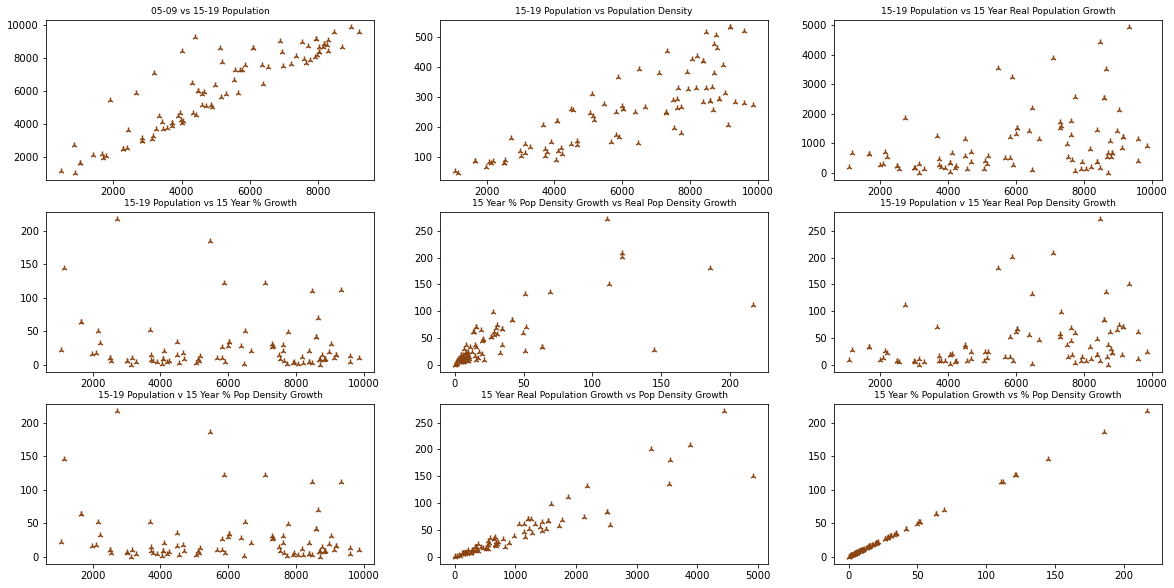

In [93]:
#long term just population
fig, axs = plt.subplots(3, 3, figsize=(20,10))
axs[0,0].scatter(df['09pop'], df['19pop'], color='saddlebrown', marker = '2')
axs[0,0].set_title("05-09 vs 15-19 Population", fontsize = 9)
axs[0,1].scatter(df['19pop'], df['19density'], color='saddlebrown', marker = '2')
axs[0,1].set_title("15-19 Population vs Population Density", fontsize = 9)
axs[0,2].scatter(df['19pop'], df['LT'], color='saddlebrown', marker = '2')
axs[0,2].set_title("15-19 Population vs 15 Year Real Population Growth", fontsize = 9)
axs[1,0].scatter(df['19pop'], df['LT%'], color='saddlebrown', marker = '2')
axs[1,0].set_title("15-19 Population vs 15 Year % Growth", fontsize = 9)
axs[1,1].scatter(df['LT%Density'], df['LTDensity'], color='saddlebrown', marker = '2')
axs[1,1].set_title("15 Year % Pop Density Growth vs Real Pop Density Growth", fontsize = 9)
axs[1,2].scatter(df['19pop'], df['LTDensity'], color='saddlebrown', marker = '2')
axs[1,2].set_title("15-19 Population v 15 Year Real Pop Density Growth", fontsize = 9)
axs[2,0].scatter(df['19pop'], df['LT%Density'], color='saddlebrown', marker = '2')
axs[2,0].set_title("15-19 Population v 15 Year % Pop Density Growth", fontsize = 9)
axs[2,1].scatter(df['LT'], df['LTDensity'], color='saddlebrown', marker = '2')
axs[2,1].set_title("15 Year Real Population Growth vs Pop Density Growth", fontsize = 9)
axs[2,2].scatter(df['LT%'], df['LT%Density'], color='saddlebrown', marker = '2')
axs[2,2].set_title("15 Year % Population Growth vs % Pop Density Growth", fontsize = 9)

Text(0.5, 1.0, 'Drive LTD%')

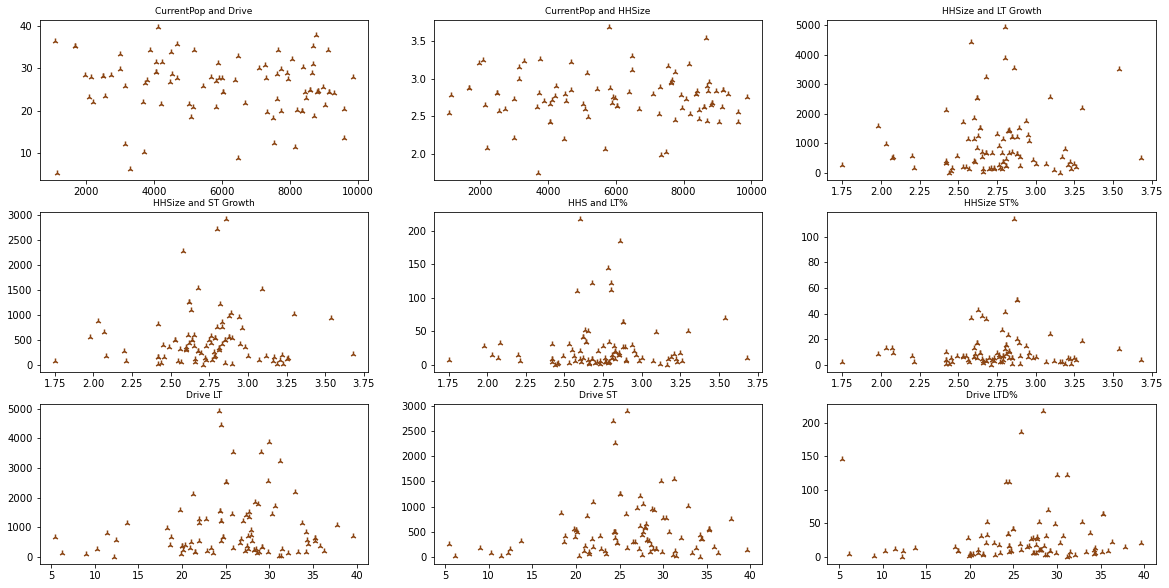

In [94]:
#population with other measures
fig, axs = plt.subplots(3, 3, figsize=(20,10))
axs[0,0].scatter(df['19pop'], df['drive'], color='saddlebrown', marker = '2')
axs[0,0].set_title("CurrentPop and Drive", fontsize = 9)
axs[0,1].scatter(df['19pop'], df['hhsize'], color='saddlebrown', marker = '2')
axs[0,1].set_title("CurrentPop and HHSize", fontsize = 9)
axs[0,2].scatter(df['hhsize'], df['LT'], color='saddlebrown', marker = '2')
axs[0,2].set_title("HHSize and LT Growth", fontsize = 9)
axs[1,0].scatter(df['hhsize'], df['ST'], color='saddlebrown', marker = '2')
axs[1,0].set_title("HHSize and ST Growth", fontsize = 9)
axs[1,1].scatter(df['hhsize'], df['LT%'], color='saddlebrown', marker = '2')
axs[1,1].set_title("HHS and LT%", fontsize = 9)
axs[1,2].scatter(df['hhsize'], df['ST%'], color='saddlebrown', marker = '2')
axs[1,2].set_title("HHSize ST%", fontsize = 9)
axs[2,0].scatter(df['drive'], df['LT'], color='saddlebrown', marker = '2')
axs[2,0].set_title("Drive LT", fontsize = 9)
axs[2,1].scatter(df['drive'], df['ST'], color='saddlebrown', marker = '2')
axs[2,1].set_title("Drive ST", fontsize = 9)
axs[2,2].scatter(df['drive'], df['LT%'], color='saddlebrown', marker = '2')
axs[2,2].set_title("Drive LTD%", fontsize = 9)

Text(0.5, 1.0, 'ST%Growth STDensity%Growth')

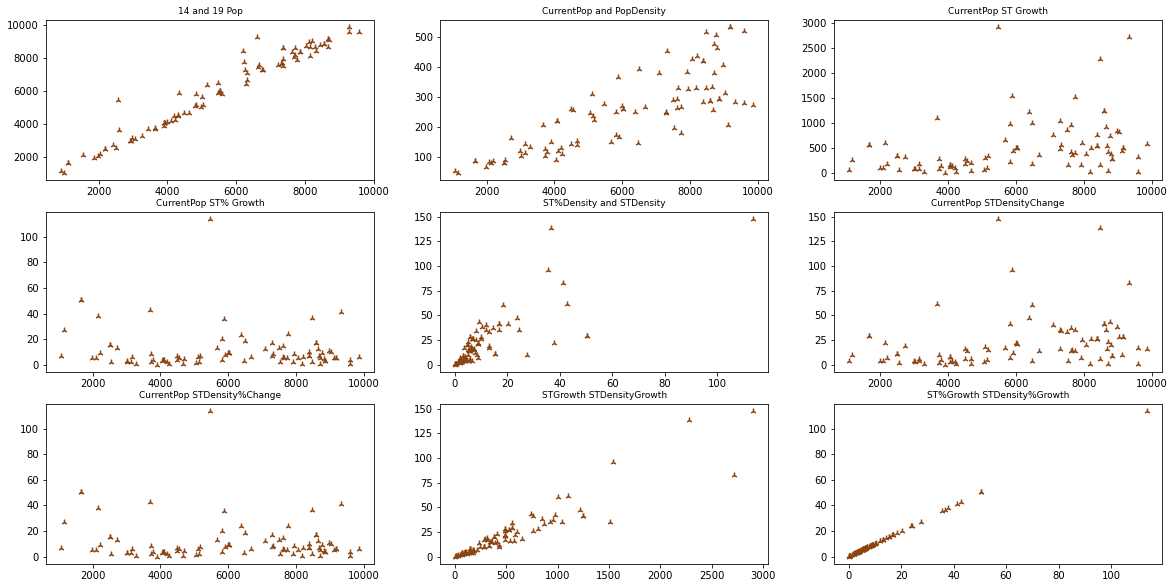

In [95]:
#short term
fig, axs = plt.subplots(3, 3, figsize=(20,10))
axs[0,0].scatter(df['14pop'], df['19pop'], color='saddlebrown', marker = '2')
axs[0,0].set_title("14 and 19 Pop", fontsize = 9)
axs[0,1].scatter(df['19pop'], df['19density'], color='saddlebrown', marker = '2')
axs[0,1].set_title("CurrentPop and PopDensity", fontsize = 9)
axs[0,2].scatter(df['19pop'], df['ST'], color='saddlebrown', marker = '2')
axs[0,2].set_title("CurrentPop ST Growth", fontsize = 9)
axs[1,0].scatter(df['19pop'], df['ST%'], color='saddlebrown', marker = '2')
axs[1,0].set_title("CurrentPop ST% Growth", fontsize = 9)
axs[1,1].scatter(df['ST%Density'], df['STDensity'], color='saddlebrown', marker = '2')
axs[1,1].set_title("ST%Density and STDensity", fontsize = 9)
axs[1,2].scatter(df['19pop'], df['STDensity'], color='saddlebrown', marker = '2')
axs[1,2].set_title("CurrentPop STDensityChange", fontsize = 9)
axs[2,0].scatter(df['19pop'], df['ST%Density'], color='saddlebrown', marker = '2')
axs[2,0].set_title("CurrentPop STDensity%Change", fontsize = 9)
axs[2,1].scatter(df['ST'], df['STDensity'], color='saddlebrown', marker = '2')
axs[2,1].set_title("STGrowth STDensityGrowth", fontsize = 9)
axs[2,2].scatter(df['ST%'], df['ST%Density'], color='saddlebrown', marker = '2')
axs[2,2].set_title("ST%Growth STDensity%Growth", fontsize = 9)

Text(0.5, 1.0, 'Drive and % Change Permits')

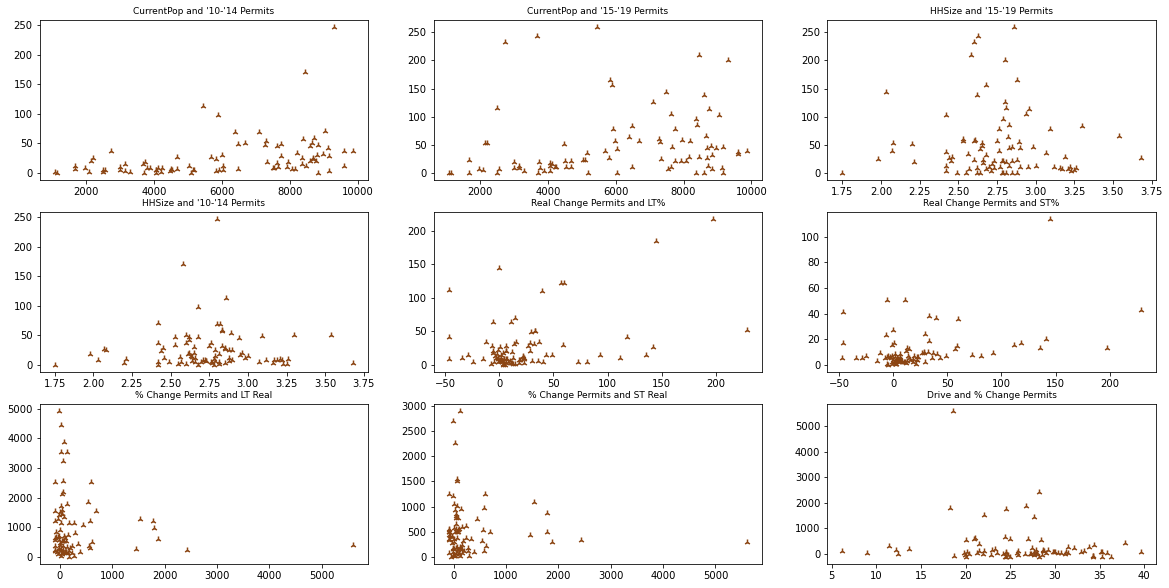

In [96]:
#permitting
fig, axs = plt.subplots(3, 3, figsize=(20,10))
axs[0,0].scatter(df['19pop'], df['14permits'], color='saddlebrown', marker = '2')
axs[0,0].set_title("CurrentPop and '10-'14 Permits", fontsize = 9)
axs[0,1].scatter(df['19pop'], df['19permits'], color='saddlebrown', marker = '2')
axs[0,1].set_title("CurrentPop and '15-'19 Permits", fontsize = 9)
axs[0,2].scatter(df['hhsize'], df['19permits'], color='saddlebrown', marker = '2')
axs[0,2].set_title("HHSize and '15-'19 Permits", fontsize = 9)
axs[1,0].scatter(df['hhsize'], df['14permits'], color='saddlebrown', marker = '2')
axs[1,0].set_title("HHSize and '10-'14 Permits", fontsize = 9)
axs[1,1].scatter(df['permreal'], df['LT%'], color='saddlebrown', marker = '2')
axs[1,1].set_title("Real Change Permits and LT%", fontsize = 9)
axs[1,2].scatter(df['permreal'], df['ST%'], color='saddlebrown', marker = '2')
axs[1,2].set_title("Real Change Permits and ST%", fontsize = 9)
axs[2,0].scatter(df['perm%'], df['LT'], color='saddlebrown', marker = '2')
axs[2,0].set_title("% Change Permits and LT Real", fontsize = 9)
axs[2,1].scatter(df['perm%'], df['ST'], color='saddlebrown', marker = '2')
axs[2,1].set_title("% Change Permits and ST Real", fontsize = 9)
axs[2,2].scatter(df['drive'], df['perm%'], color='saddlebrown', marker = '2')
axs[2,2].set_title("Drive and % Change Permits", fontsize = 9)

In [97]:
df = df.reset_index(drop=True)

In [98]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   GEOID       90 non-null     object  
 1   NAME        90 non-null     object  
 2   NAMELSAD    90 non-null     object  
 3   geometry    90 non-null     geometry
 4   SQMILES     90 non-null     float64 
 5   StateFIPS   90 non-null     object  
 6   PlaceFIPS   90 non-null     object  
 7   09pop       90 non-null     float64 
 8   14pop       90 non-null     float64 
 9   19pop       90 non-null     float64 
 10  hhsize      90 non-null     float64 
 11  drive       90 non-null     float64 
 12  ST%         90 non-null     float64 
 13  ST          90 non-null     float64 
 14  LT%         90 non-null     float64 
 15  LT          90 non-null     float64 
 16  State       90 non-null     object  
 17  19density   90 non-null     float64 
 18  14density   90 non-null     float64 
 19  09

In [99]:
df.to_file('../data/geo/ALLPLACES.shp')

Now we finish with an index-ordered dataframe with multiple numeric columns containing no null or zero values, perfect for scikit learn and its k means clustering algorithms.